<a href="https://colab.research.google.com/github/sujalgawas/brain_tumour/blob/main/tumor_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import torch,gc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models,datasets
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import opendatasets as od

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
dataset_url = 'https://www.kaggle.com/datasets/jarvisgroot/brain-tumor-classification-mri-images?select=brain_tumor_mri'
dataset_url_1 = 'https://www.kaggle.com/datasets/jarvisgroot/brain-tumor-classification-mri-images?select=test_images-20210704T210303Z-001'

od.download(dataset_url)
od.download(dataset_url_1)

Dataset URL: https://www.kaggle.com/datasets/jarvisgroot/brain-tumor-classification-mri-images


100%|██████████| 633M/633M [00:39<00:00, 16.9MB/s]



Skipping, found downloaded files in "./brain-tumor-classification-mri-images" (use force=True to force download)


In [5]:
torch.cuda.empty_cache()

In [6]:
training_data = pickle.load(open('/content/brain-tumor-classification-mri-images/brain_tumor_mri/new_dataset/training_data.pickle', 'rb'))

In [7]:
class BrainTumorDataset(Dataset):
  def __init__(self, images, labels):
    # images
    self.X = images
    # labels
    self.y = labels

    # Transformation for converting original image array to an image and then convert it to a tensor
    self.transform = transforms.Compose([transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -45 degrees and 45 degrees, and then convert it to a tensor
    self.transform1 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(45),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -90 degrees and 90 degrees, and then convert it to a tensor
    self.transform2 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(90),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -120 degrees and 120 degrees, and then convert it to a tensor
    self.transform3 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(120),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -180 degrees and 180 degrees, and then convert it to a tensor
    self.transform4 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(180),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -270 degrees and 270 degrees, and then convert it to a tensor
    self.transform5 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(270),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -300 degrees and 300 degrees, and then convert it to a tensor
    self.transform6 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(300),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -330 degrees and 330 degrees, and then convert it to a tensor
    self.transform7 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(330),
        transforms.ToTensor()
    ])

  def __len__(self):
    # return length of image samples
    return len(self.X)

  def __getitem__(self, idx):
    # perform transformations on one instance of X
    # Original image as a tensor
    data = self.transform(self.X[idx])

    # Augmented image at 45 degrees as a tensor
    aug45 = self.transform1(self.X[idx])

    # Augmented image at 90 degrees as a tensor
    aug90 = self.transform2(self.X[idx])

    # Augmented image at 120 degrees as a tensor
    aug120 = self.transform3(self.X[idx])

    # Augmented image at 180 degrees as a tensor
    aug180 = self.transform4(self.X[idx])

    # Augmented image at 270 degrees as a tensor
    aug270 = self.transform5(self.X[idx])

    # Augmented image at 300 degrees as a tensor
    aug300 = self.transform6(self.X[idx])

    # Augmented image at 330 degrees as a tensor
    aug330 = self.transform7(self.X[idx])

    # store the transformed images in a list
    new_batch = [data, aug45, aug90, aug120, aug180, aug270, aug300, aug330]

    # one-hot encode the labels
    labels = torch.zeros(4, dtype=torch.float32)
    labels[int(self.y[idx])] = 1.0

    new_labels = [labels, labels, labels, labels, labels, labels, labels, labels]

    # 8 augmented images and corresponding labels per sample will be returned
    return (torch.stack(new_labels), torch.stack(new_batch))

In [8]:
Xt = []
yt = []
features = None
labels = None
label = []

In [9]:
for features,labels in training_data:
  Xt.append(features)
  yt.append(labels)

In [10]:
len(yt)

3064

In [11]:
# 70 % training, 15% validating, 15% testing
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.3, shuffle=True)  # 70% training, 30% testing
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)  # split testing set into 50% validation , 50% testing

In [12]:
Xt = None
yt = None
features = None
labels = None
label = None
training_data = None

In [13]:
train_set = BrainTumorDataset(X_train, y_train)
valid_set = BrainTumorDataset(X_valid, y_valid)
test_set = BrainTumorDataset(X_test, y_test)

In [14]:
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_valid)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 2144
Number of validation samples: 460
Number of testing samples: 460


In [15]:
train_gen = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=2)
valid_gen = DataLoader(valid_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=2)
test_gen = DataLoader(test_set, batch_size=10, shuffle=True, pin_memory=True, num_workers=2)

Train batch - images shape: torch.Size([4, 8, 4]) labels shape: torch.Size([4, 8, 3, 512, 512])


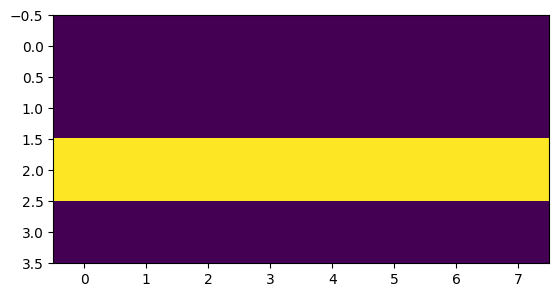

In [16]:
for images, labels in train_gen:
    print("Train batch - images shape:", images.shape, "labels shape:", labels.shape)

    # Display the first image in the batch
    img = images[0].permute(1, 0)
    plt.imshow(img)
    plt.show()
    break

Test batch - images shape: torch.Size([10, 8, 4]) labels shape: torch.Size([10, 8, 3, 512, 512])


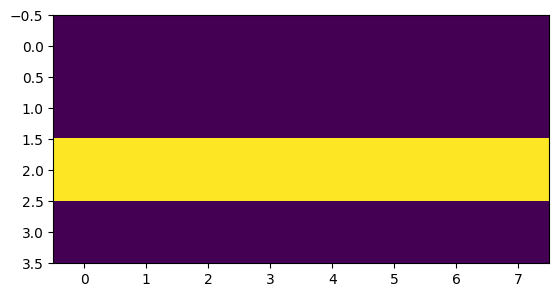

In [17]:
for images, labels in test_gen:
    print("Test batch - images shape:", images.shape, "labels shape:", labels.shape)
    img = images[0].permute(1, 0)
    plt.imshow(img)
    plt.show()
    break

Test batch - images shape: torch.Size([4, 8, 4]) labels shape: torch.Size([4, 8, 3, 512, 512])


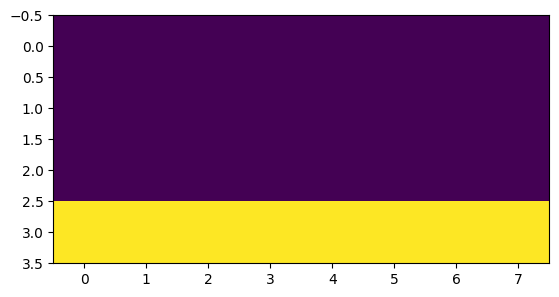

In [18]:
for images, labels in valid_gen:
    print("Test batch - images shape:", images.shape, "labels shape:", labels.shape)
    img = images[0].permute(1, 0)
    plt.imshow(img)
    plt.show()
    break

In [19]:
resnet_model = models.resnet50(pretrained=True)

# set all paramters as trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# get input of fc layer
n_inputs = resnet_model.fc.in_features

# redefine fc layer / top layer/ head for our classification problem
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 64),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(64, 64),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(64, 4),
                                nn.LogSigmoid())

# set all paramters of the model as trainable
for name, child in resnet_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

# set model to run on GPU or CPU absed on availibility
resnet_model.to(device)

# print the trasnfer learning NN model's architecture
resnet_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
torch.cuda.empty_cache()

In [21]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(resnet_model.parameters(), momentum=0.9, lr=3e-4)

# number of training iterations
epochs = 5

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [23]:
# set training start time
start_time = time.time()


# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0

    # set epoch's starting time
    e_start = time.time()

    # train in batches
    for b, (y, X) in enumerate(train_gen):
        # set label as cuda if device is cuda

        X = X.to(device)
        y= y.to(device)

          # forward pass image sample
        y_pred = resnet_model(X.view(-1, 3, 512, 512))
        gc.collect()
        torch.cuda.empty_cache()
          # calculate loss
        loss = criterion(y_pred.float(), torch.argmax(y.view(32, 4), dim=1).long())

          # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
          # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(32, 4), dim=1)).sum()
          # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr

          # set optimizer gradients to zero
        optimizer.zero_grad()
          # back propagate with loss
        loss.backward()
          # perform optimizer step
        optimizer.step()


    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*4}\nAccuracy: {trn_corr.item()*100/(4*8*b):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(valid_gen):
            X, y = X.to(device), y.to(device)

                # forward pass image
            y_val = resnet_model(X.view(-1, 3, 512, 512))

                # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

                # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(32, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(32, 4), dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(4*8*b):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1 Batch 2144
Accuracy: 59.92 %  Loss: 0.4568  Duration: 12.67 minutes
Validation Accuracy 71.24 Validation Loss: 0.7508

Epoch 2 Batch 2144
Accuracy: 75.12 %  Loss: 0.2602  Duration: 12.66 minutes
Validation Accuracy 76.10 Validation Loss: 0.3491

Epoch 3 Batch 2144
Accuracy: 81.26 %  Loss: 0.3684  Duration: 12.66 minutes
Validation Accuracy 86.10 Validation Loss: 0.2023

Epoch 4 Batch 2144
Accuracy: 85.58 %  Loss: 0.7551  Duration: 12.66 minutes
Validation Accuracy 89.75 Validation Loss: 0.2830

Epoch 5 Batch 2144
Accuracy: 85.62 %  Loss: 0.9065  Duration: 12.66 minutes
Validation Accuracy 88.79 Validation Loss: 0.2325


Training Duration 68.02 minutes
GPU memory used : 406416896 kb
GPU memory cached : 15124660224 kb


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [26]:
resnet_model.eval()

# perform no gradient updates
with torch.no_grad():
    # soem metrics storage for visualization and analysis
    correct = 0
    test_loss = []
    test_corr = []
    labels = []
    pred = []
    # perform test set evaluation batch wise
    for (y, X) in test_gen:
        # set label to use CUDA if available
        X, y = X.to(device), y.to(device)

        # append original labels
        labels.append(torch.argmax(y.view(10 * 8, 4), dim=1).data)

        # perform forward pass
        y_val = resnet_model(X.view(-1, 3, 512, 512))

        # get argmax of predicted values, which is our label
        predicted = torch.argmax(y_val, dim=1).data
        # append predicted label
        pred.append(predicted)

        # calculate loss
        loss = criterion(y_val.float(), torch.argmax(y.view(10 * 8, 4), dim=1).long())

        # increment correct with correcly predicted labels per batch
        correct += (predicted == torch.argmax(y.view(10 * 8, 4), dim=1)).sum()

        # append correct samples labels and losses
        test_corr.append(correct)
        test_loss.append(loss)

print(f"Test Loss: {test_loss[-1].item():.4f}")

Test Loss: 0.1735


In [27]:
print(f'Test accuracy: {test_corr[-1].item()*100/(460*8):.2f}%')

Test accuracy: 94.38%


In [28]:
labels = torch.stack(labels)
pred = torch.stack(pred)

In [29]:
LABELS = ['Meningioma', 'Glioma', 'Pitutary']

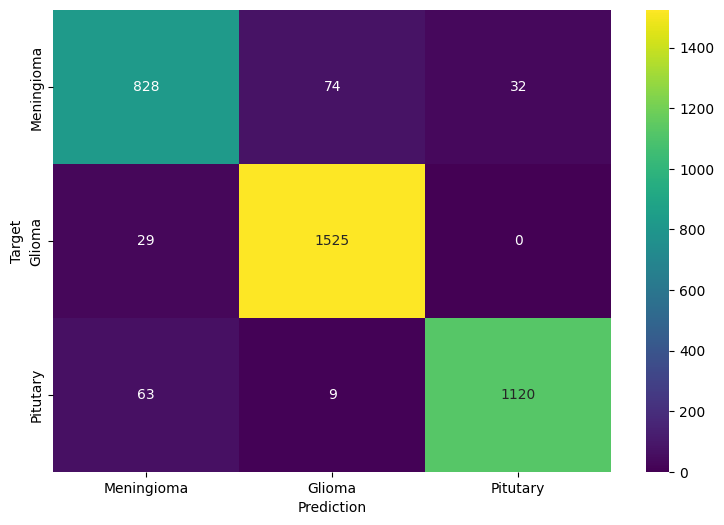

In [30]:
arr = confusion_matrix(pred.view(-1).cpu(), labels.view(-1).cpu())
df_cm = pd.DataFrame(arr, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()